<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/misc_examples/Example_of_Multiple_Sequence_Input_Modes_With_DeepSHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow #show the tensorflow version for documentation purposes
tensorflow.__version__

'1.15.0'

In [2]:
import keras

#create a dummy model
def create_branch():
  inp = keras.layers.Input((153,4))
  out = keras.layers.Conv1D(filters=128, kernel_size=10, padding='same', activation="relu")(inp)
  out = keras.layers.Dropout(0.3)(out)
  out = keras.layers.MaxPooling1D(pool_size=3, strides=3)(out)
  out = keras.layers.Conv1D(filters=128, kernel_size=10, padding='same', activation="relu")(out)
  out = keras.layers.Dropout(0.3)(out)
  out = keras.layers.MaxPooling1D(pool_size=3, strides=3)(out)
  out = keras.layers.Flatten()(out)
  return inp, out

inp1, branch_out1 = create_branch()
inp2, branch_out2 = create_branch()
inp3, branch_out3 = create_branch()
out = keras.layers.Concatenate(axis=-1)([branch_out1, branch_out2, branch_out3])
out = keras.layers.Dense(16, activation="relu")(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(1, activation="sigmoid")(out)
model = keras.Model(inputs=[inp1, inp2, inp3], outputs=out)
model.compile(loss="binary_crossentropy", optimizer="adam")





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Using TensorFlow backend.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
!pip install deeplift #for dinuc shuffle functionality

In [4]:
#I am using my personal fork of Scott Lundberg's shap
# repository because it has some custom functionality.
#Also the latest version of the shap repo has a warning saying
# there is no longer support for keras, and that it's necessary to use tf.keras
!git clone https://github.com/AvantiShri/shap.git
%cd /content/shap
!pip install .
%cd /content

from importlib import reload
import shap

fatal: destination path 'shap' already exists and is not an empty directory.
/content/shap
Processing /content/shap
  Created wheel for shap: filename=shap-0.29.3-cp36-cp36m-linux_x86_64.whl size=347366 sha256=72c27deb466f7abc82507424b52daf41dc20e40ca86eb13c2e5ef3b0ee068629
  Stored in directory: /tmp/pip-ephem-wheel-cache-jhimyvdk/wheels/08/fe/b1/461bb216b26aa22db99708d72d320d2f3637775309af9f79b5
Successfully built shap
  Found existing installation: shap 0.29.3
    Uninstalling shap-0.29.3:
      Successfully uninstalled shap-0.29.3
/content


In [5]:
import numpy as np

def gen_random_onehot(batch_size): #generate random one-hot encoded inputs
  rand_arr = np.random.random((batch_size, 153, 4))
  last_axis_argmax = np.argmax(rand_arr, axis=-1)
  zeros_arr = np.zeros((batch_size, 153, 4))
  indices = np.indices(last_axis_argmax.shape)
  zeros_arr[indices[0], indices[1], last_axis_argmax] = 1
  return zeros_arr

def gen_random_model_input(batch_size):
  return [gen_random_onehot(batch_size),
          gen_random_onehot(batch_size),
          gen_random_onehot(batch_size)]

#generate a batch of random model inputs
rand_input = gen_random_model_input(10)
model.predict(rand_input)

array([[0.59299713],
       [0.5750043 ],
       [0.5904002 ],
       [0.572551  ],
       [0.5839555 ],
       [0.5567311 ],
       [0.5953138 ],
       [0.5902258 ],
       [0.59440976],
       [0.5850128 ]], dtype=float32)

In [0]:
import numpy as np
from deeplift.dinuc_shuffle import dinuc_shuffle

#this is a function to dynamically generate
# a set of references for a given example
def reference_generator(single_example):
  num_refs_per_ex = 20 #number of references per example
  rng = np.random.RandomState(1234) #random number generator
  #for this model, single_example should have length 3,
  # one entry for each input mode
  assert len(single_example)==3
  #for this model, the individual entries
  # in single_example should have dims of 153,4
  # which are the model input dims for each mode
  assert single_example[0].shape==(153,4)
  assert single_example[1].shape==(153,4)
  assert single_example[2].shape==(153,4)

  #generate a batch of references. This will have
  # length 3, one entry for each input mode, and each
  # entry will have dimensions of (batch_size, 153, 4)
  reference_batch = []
  for input_sequence in single_example:
    #note: if you DIDN'T want to scramble a particular input mode, then
    # for that input mode you should just make num_refs_per_ex
    # copies of the original sequence, i.e. you would do
    # reference_batch.append(np.array([input_seqeunce for i in num_refs_per_ex]))
    #Assuming you want a shuffled reference for this input mode, let's
    # generate a batch of shuffled references. I'm going to use joblib
    # to parallelize the shuffling because this can be a bottleneck.
    #Note that for determinism, I supply a different RandomState object to each
    # call to dinuc_shuffle
    #Incidentally, this on-the-fly dinucleotide shuffling is a bit of
    # a bottleneck; if you want to speed things up, it may be worth
    # pre-generating some references and retrieving them as needed.
    #For example, one could pre-generate dinucleotide-shuffled sequences of
    # varying GC content, and then retrieve a reference
    # that matches the GC-content of supplied sequence.
    reference_batch.append(np.array([dinuc_shuffle(input_sequence, rng=rng)
                                     for i in range(num_refs_per_ex)]))
  return reference_batch

In [7]:
import shap
#Note that if your final output layer is
# a saturating nonlinearity such as a sigmoid, you likely want to
# use the pre-sigmoid tensor as the target of the explanation. This tensor can be
# accessed with keras_model.output.op.inputs[0]. If you had actually wanted the
# very last output tensor (e.g. for regression), you would just use
# keras_model.output instead.
tensor_for_explanation = model.output.op.inputs[0]
print("tensor for explanation:", tensor_for_explanation)
#Doing tensor_for_explanation[:,0] specifies that we want to comput explanations
# w.r.t. task idx 0 in the layer.
explainer = shap.DeepExplainer(model=(model.input, tensor_for_explanation[:,0]),
                               data=reference_generator)

tensor for explanation: Tensor("dense_2/BiasAdd:0", shape=(?, 1), dtype=float32)


In [8]:
#IMPORTANT: you must sum up the contributions along the ACGT axis and project
# onto the base that's actually present. The reason for this is that deeplift/deepshap
# can give importance to any input feature that is different from its value
# in the reference. So if the actual input at a particular position is
# [1,0,0,0] (“A”) and the reference input at that position is [0,1,0,0] (“C”),
# then the difference-from-reference at that position is [1, -1, 0, 0].
# Thus, both the "A" and the "C" position can be assigned a contribution (where
# the contribution assigned to the "C" position has the interpretation of being
# the contribution due to the *absence* of the "C"). However, if a
# sequence is one-hot-encoded, having an “A” at a position is equivalent to
# NOT having a “C” at that position. Thus, we sum up the deeplift/deepshap contribution
# across all bases at a position, and “project” that summed importance onto
# whichever base is actually present at that position. Otherwise, you will get
# importance assigned to bases that are not present in the sequence, which
# is confusing to visualize.
unprojected_contributions = explainer.shap_values(rand_input, progress_message=5)
#do the projection:
final_contributions = [np.sum(unproj_contribs, axis=-1)[:,:,None]*onehot
                       for unproj_contribs, onehot
                       in zip(unprojected_contributions, rand_input)]


Done 0 examples of 10
Done 5 examples of 10


In [9]:
#visualize
!pip install vizsequence

contribution of 1st input mode:


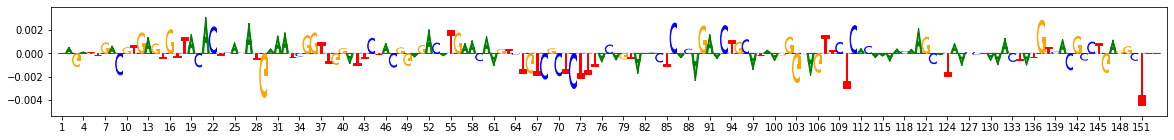

contribution of 2nd input mode:


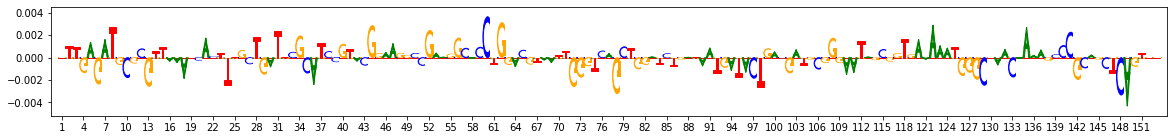

contribution of 3rd input mode:


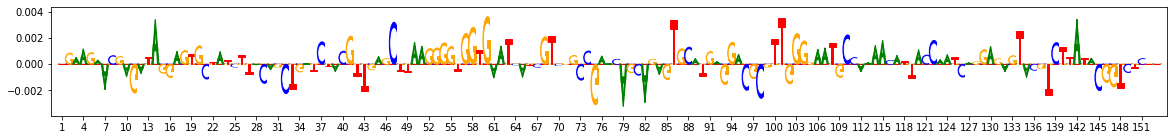

In [10]:
import vizsequence
example_idx = 0
print("contribution of 1st input mode:")
vizsequence.plot_weights(final_contributions[0][example_idx])
print("contribution of 2nd input mode:")
vizsequence.plot_weights(final_contributions[1][example_idx])
print("contribution of 3rd input mode:")
vizsequence.plot_weights(final_contributions[2][example_idx])